In [1]:
import zstandard as zstd

In [2]:
# create lookup of true size and platform for each run so we can compute the relative size and split by platform
true_size_lookup = dict()
platform_lookup = dict()
with open("../config/bacteria_lr_runs.filtered.tsv") as f:
    _ = f.readline()  # skip header
    for line in f:
        parts = line.strip().split("\t")
        run = parts[0]
        true_size = int(parts[11])
        platform = parts[14]  # 15th column (1-indexed) = 14th column (0-indexed)
        true_size_lookup[run] = true_size
        platform_lookup[run] = platform

In [3]:
rows = {}
with open("per_read_est_lrge.csv") as f:
    for line in f:
        parts = line.strip().split(",")
        read_id = parts[0]
        estimate = float(parts[1])
        method = parts[2]
        if method != "2set":
            continue
        run = read_id.split(".")[0]
        true_size = true_size_lookup[run]
        platform = platform_lookup[run]
        relative_size = estimate / true_size
        relative_error = (estimate - true_size) / true_size * 100
        rows[read_id] = (estimate, method, run, true_size, relative_size, relative_error, platform)

In [4]:
with open("reads_with_est.info.tsv") as f:
    for line in f:
        parts = line.strip().split("\t")
        read_id = parts[0]
        rlen = int(parts[1])
        rqual = float(parts[2])
        if read_id in rows:
            estimate, method, run, true_size, relative_size, relative_error, platform = rows[read_id]
            rows[read_id] = (estimate, true_size, relative_size, relative_error, rlen, rqual, platform)
        else:
            continue

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create DataFrame from the collected data
data_list = []
for read_id, (estimate, true_size, relative_size, relative_error, rlen, rqual, platform) in rows.items():
    data_list.append({
        'read_id': read_id,
        'estimate': estimate,
        'true_size': true_size,
        'relative_size': relative_size,
        'relative_error': abs(relative_error),
        'read_length': rlen,
        'read_quality': rqual,
        'platform': platform
    })

df = pd.DataFrame(data_list)

# Handle infinity values in estimates and relative errors
finite_estimates = df[np.isfinite(df['estimate'])]['estimate']
finite_relative_errors = df[np.isfinite(df['relative_error'])]['relative_error']

if len(finite_estimates) > 0:
    max_finite_estimate = finite_estimates.max()
    max_finite_rel_error = finite_relative_errors.max()
    
    # Set infinity estimates to 10x the maximum finite estimate
    replacement_estimate = max_finite_estimate * 10
    replacement_rel_error = max_finite_rel_error * 10
    
    # Count infinity values before replacement
    inf_estimate_count = np.isinf(df['estimate']).sum()
    inf_rel_error_count = np.isinf(df['relative_error']).sum()
    
    print(f"Found {inf_estimate_count} infinity estimates and {inf_rel_error_count} infinity relative errors")
    print(f"Replacing infinity estimates with {replacement_estimate:.2e}")
    print(f"Replacing infinity relative errors with {replacement_rel_error:.2f}%")
    
    # Replace infinity values
    df.loc[np.isinf(df['estimate']), 'estimate'] = replacement_estimate
    df.loc[np.isinf(df['relative_error']), 'relative_error'] = replacement_rel_error
    
    # Recalculate relative_size for replaced estimates
    df.loc[df['estimate'] == replacement_estimate, 'relative_size'] = replacement_estimate / df.loc[df['estimate'] == replacement_estimate, 'true_size']

print(f"Dataset contains {len(df)} reads")
print(f"Dataset overview:")
print(df.describe())

Found 560556 infinity estimates and 560556 infinity relative errors
Replacing infinity estimates with 1.79e+10
Replacing infinity relative errors with 773100.20%
Dataset contains 16850000 reads
Dataset overview:
           estimate     true_size  relative_size  relative_error  \
count  1.685000e+07  1.685000e+07   1.685000e+07    1.685000e+07   
mean   6.021683e+08  5.125015e+06   1.287842e+02    2.578054e+04   
std    3.207631e+09  2.240956e+06   7.820201e+02    1.386320e+05   
min    1.357115e+04  6.813740e+05   4.870649e-03    0.000000e+00   
25%    3.420296e+06  3.558757e+06   8.790167e-01    1.093497e+01   
50%    5.367458e+06  4.967140e+06   1.097576e+00    2.539932e+01   
75%    8.218119e+06  6.275453e+06   1.453374e+00    5.824514e+01   
max    1.789339e+10  1.350515e+07   2.626074e+04    7.731002e+05   

        read_length  read_quality  
count  1.685000e+07  1.685000e+07  
mean   7.603486e+03  1.154230e+01  
std    9.247247e+03  8.690344e+00  
min    1.100000e+01 -0.000000e+

In [6]:
# Check the available platforms
print("Available platforms:")
platform_counts = df['platform'].value_counts()
print(platform_counts)
print(f"\nTotal platforms: {len(platform_counts)}")

# Also check a few sample platform names
print(f"\nSample platform names: {df['platform'].unique()[:10]}")

Available platforms:
platform
OXFORD_NANOPORE    12340000
PACBIO_SMRT         4510000
Name: count, dtype: int64

Total platforms: 2

Sample platform names: ['OXFORD_NANOPORE' 'PACBIO_SMRT']


Using 16,850,000 samples (100.0%) for scatter plots
=== LINEAR REGRESSION ANALYSIS (Read Length vs Relative Error) ===
OXFORD_NANOPORE:
  Sample size: 12,339,998
  Slope: -0.5782
  Intercept: 3.4483
  R²: 0.1291
  F-statistic: 1829508.09
  Overall p-value: 1.11e-16
  Slope t-statistic: -1352.59
  Slope p-value: 0.00e+00

PACBIO_SMRT:
  Sample size: 4,509,999
  Slope: -1.1338
  Intercept: 6.0609
  R²: 0.1389
  F-statistic: 727229.86
  Overall p-value: 1.11e-16
  Slope t-statistic: -852.78
  Slope p-value: 0.00e+00

=== LINEAR REGRESSION ANALYSIS (Read Quality vs Relative Error) ===
OXFORD_NANOPORE:
  Sample size: 12,339,998
  Slope: -0.0191
  Intercept: 1.6512
  R²: 0.0077
  F-statistic: 95587.85
  Overall p-value: 1.11e-16
  Slope t-statistic: -309.17
  Slope p-value: 0.00e+00

PACBIO_SMRT:
  Sample size: 4,509,999
  Slope: -0.0079
  Intercept: 1.8219
  R²: 0.0098
  F-statistic: 44802.86
  Overall p-value: 1.11e-16
  Slope t-statistic: -211.67
  Slope p-value: 0.00e+00

Statistical sig

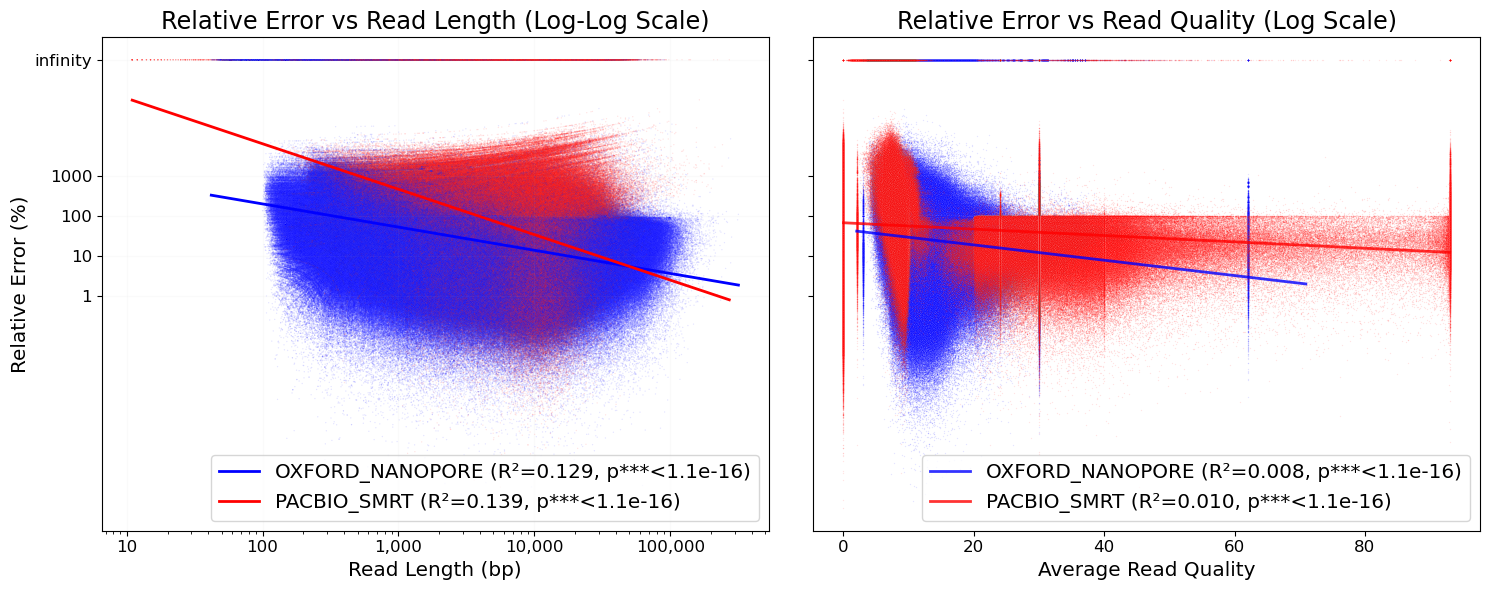

In [14]:
# Plot: Relative Error vs Read Length and Quality (Log Scale) by Platform (using 1% sample for faster plotting)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Sample 1% of the data for faster plotting
sample_size = int(len(df))# * 0.01)
df_sample = df.sample(n=sample_size, random_state=42)
print(f"Using {len(df_sample):,} samples ({len(df_sample)/len(df)*100:.1f}%) for scatter plots")

# Filter out zero values for log scale (since relative_error is already absolute)
nonzero_mask = df_sample['relative_error'] > 0
df_sample_nonzero = df_sample[nonzero_mask]

# Define colors for platforms
platform_colors = {
    'OXFORD_NANOPORE': 'blue',
    'PACBIO_SMRT': 'red'
}

# Plot 1: Relative Error vs Read Length (log-log scale) by Platform
sns.scatterplot(
    data=df_sample_nonzero,
    x='read_length',
    y='relative_error',
    hue='platform',
    palette=platform_colors,
    ax=ax1,
    alpha=0.1,
    s=1,
    legend=False  # We'll add legend with regression lines
)

ax1.set_xlabel('Read Length (bp)', fontsize="x-large")
ax1.set_ylabel('Relative Error (%)', fontsize="x-large")
ax1.set_title('Relative Error vs Read Length (Log-Log Scale)', fontsize="xx-large")
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.grid(True, alpha=0.05)
ax1.tick_params(axis='both', which='major', labelsize="large")

# Add linear regression lines for each platform (in log-log space)
# Use full dataset for regression for better statistical power
from sklearn.linear_model import LinearRegression
from scipy import stats
import numpy as np

# Filter out zero values for log scale from full dataset (since relative_error is already absolute)
nonzero_mask_full = df['relative_error'] > 0

print("=== LINEAR REGRESSION ANALYSIS (Read Length vs Relative Error) ===")
for platform in df['platform'].unique():
    platform_mask_full = (df['platform'] == platform) & nonzero_mask_full
    if platform_mask_full.sum() > 100:  # Only fit if we have enough data points
        X = np.log10(df[platform_mask_full]['read_length'].values).reshape(-1, 1)  # Log of x
        y = np.log10(df[platform_mask_full]['relative_error'])  # Log of y for log scale
        
        # Fit linear regression
        reg = LinearRegression().fit(X, y)
        
        # Calculate R-squared and p-value
        y_pred_stats = reg.predict(X)
        r_squared = reg.score(X, y)
        
        # Calculate F-statistic and p-value for overall regression significance
        n = len(y)
        k = X.shape[1]  # number of predictors
        mse_residual = np.sum((y - y_pred_stats)**2) / (n - k - 1)
        mse_total = np.sum((y - np.mean(y))**2) / (n - 1)
        f_statistic = (r_squared / k) / ((1 - r_squared) / (n - k - 1))
        p_value = 1 - stats.f.cdf(f_statistic, k, n - k - 1)
        
        # Calculate t-statistic and p-value for slope coefficient
        residuals = y - y_pred_stats
        mse = np.sum(residuals**2) / (n - 2)
        x_centered = X.flatten() - np.mean(X.flatten())
        se_slope = np.sqrt(mse / np.sum(x_centered**2))
        t_statistic = reg.coef_[0] / se_slope
        slope_p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), n - 2))
        
        print(f"{platform}:")
        print(f"  Sample size: {n:,}")
        print(f"  Slope: {reg.coef_[0]:.4f}")
        print(f"  Intercept: {reg.intercept_:.4f}")
        print(f"  R²: {r_squared:.4f}")
        print(f"  F-statistic: {f_statistic:.2f}")
        print(f"  Overall p-value: {p_value:.2e}")
        print(f"  Slope t-statistic: {t_statistic:.2f}")
        print(f"  Slope p-value: {slope_p_value:.2e}")
        print()
        
        # Create prediction line
        x_range = np.logspace(np.log10(df[platform_mask_full]['read_length'].min()), 
                             np.log10(df[platform_mask_full]['read_length'].max()), 100)
        y_pred = reg.predict(np.log10(x_range).reshape(-1, 1))
        
        # Add significance indicator to label
        sig_indicator = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        
        ax1.plot(x_range, 10**y_pred, 
                color=platform_colors[platform], 
                linewidth=2, 
                linestyle='-',
                label=f'{platform} (R²={r_squared:.3f}, p{sig_indicator}<{p_value:.1e})')

# Add infinity label to the specific tick where we placed infinity values
from matplotlib.ticker import FixedLocator, FixedFormatter

yticks = ax1.get_yticks()
infinity_value = replacement_rel_error  # The value we used to replace infinity

# Always include the infinity value as a tick
new_yticks = [1, 10, 100, 1000, infinity_value]
# Remove any existing ticks that are very close to the infinity value
# new_yticks = [tick for tick in new_yticks if abs(tick - infinity_value) > infinity_value * 0.1]
# Add the exact infinity value
# new_yticks.append(infinity_value)
# new_yticks.sort()

# Create corresponding labels
ytick_labels = []
for tick in new_yticks:
    if tick == infinity_value:  # If tick is the exact infinity replacement value
        ytick_labels.append('infinity')
    else:
        ytick_labels.append(tick)

ax1.legend(fontsize="x-large", loc="lower right")

# Plot 2: Absolute Relative Error vs Read Quality (log scale) by Platform
import seaborn as sns

# Create sample data with only non-zero relative errors for log scale
sample_nonzero = df_sample[nonzero_mask].copy()

# Use seaborn for the scatter plot
for platform in sample_nonzero['platform'].unique():
    platform_data = sample_nonzero[sample_nonzero['platform'] == platform]
    sns.scatterplot(data=platform_data, x='read_quality', y='relative_error',
                   color=platform_colors[platform], alpha=0.1, s=1, ax=ax2)

ax2.set_xlabel('Average Read Quality', fontsize="x-large")
ax2.set_ylabel('Absolute Relative Error', fontsize="x-large")
ax2.set_title('Relative Error vs Read Quality (Log Scale)', fontsize="xx-large")
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize="large")

# Apply same custom y-axis ticks as plot 1
ax2.set_yticks(new_yticks)
ax2.set_yticklabels(ytick_labels)

# Add linear regression lines for each platform (read quality vs relative error)
print("=== LINEAR REGRESSION ANALYSIS (Read Quality vs Relative Error) ===")
for platform in df['platform'].unique():
    platform_mask_full = (df['platform'] == platform) & nonzero_mask_full
    if platform_mask_full.sum() > 100:  # Only fit if we have enough data points
        X = df[platform_mask_full]['read_quality'].values.reshape(-1, 1)  # Quality (linear)
        y = np.log10(df[platform_mask_full]['relative_error'])  # Log of y for log scale
        
        # Fit linear regression
        reg = LinearRegression().fit(X, y)
        
        # Calculate R-squared and p-value
        y_pred_stats = reg.predict(X)
        r_squared = reg.score(X, y)
        
        # Calculate F-statistic and p-value for overall regression significance
        n = len(y)
        k = X.shape[1]  # number of predictors
        f_statistic = (r_squared / k) / ((1 - r_squared) / (n - k - 1))
        p_value = 1 - stats.f.cdf(f_statistic, k, n - k - 1)
        
        # Calculate t-statistic and p-value for slope coefficient
        residuals = y - y_pred_stats
        mse = np.sum(residuals**2) / (n - 2)
        x_centered = X.flatten() - np.mean(X.flatten())
        se_slope = np.sqrt(mse / np.sum(x_centered**2))
        t_statistic = reg.coef_[0] / se_slope
        slope_p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), n - 2))
        
        print(f"{platform}:")
        print(f"  Sample size: {n:,}")
        print(f"  Slope: {reg.coef_[0]:.4f}")
        print(f"  Intercept: {reg.intercept_:.4f}")
        print(f"  R²: {r_squared:.4f}")
        print(f"  F-statistic: {f_statistic:.2f}")
        print(f"  Overall p-value: {p_value:.2e}")
        print(f"  Slope t-statistic: {t_statistic:.2f}")
        print(f"  Slope p-value: {slope_p_value:.2e}")
        print()
        
        # Create prediction line
        x_range = np.linspace(df[platform_mask_full]['read_quality'].min(), 
                             df[platform_mask_full]['read_quality'].max(), 100)
        y_pred = reg.predict(x_range.reshape(-1, 1))
        
        # Add significance indicator to label
        sig_indicator = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
        
        # Plot regression line
        ax2.plot(x_range, 10**y_pred, '-', color=platform_colors[platform], linewidth=2, alpha=0.8, 
                label=f'{platform} (R²={r_squared:.3f}, p{sig_indicator}<{p_value:.1e})')

ax2.legend(fontsize="x-large", loc="lower right")

# Add statistical significance legend
print("Statistical significance: *** p<0.001, ** p<0.01, * p<0.05")

ax1_xticks = [10, 100, 1000, 10000, 100000]
ax1.set_xticks(ax1_xticks)
ax1.set_xticklabels([f'{x:,}' for x in ax1_xticks])

plt.tight_layout()
plt.show()

In [16]:
fig.savefig("relerr_vs_len_qual.png")

## Figure Caption

**Figure 1. Impact of read characteristics on genome size estimation accuracy across sequencing platforms.**

**(A)** Relationship between read length and absolute relative error in genome size estimation for Oxford Nanopore (blue) and PacBio SMRT (red) technologies. Data points represent individual reads (n=16.85M) plotted on log-log scales. Linear regression lines show significant negative correlations for both platforms (Oxford Nanopore: R²=0.129, slope=-0.58, p<1×10⁻¹⁶; PacBio SMRT: R²=0.139, slope=-1.13, p<1×10⁻¹⁶), indicating that longer reads yield more accurate genome size estimates. PacBio SMRT shows a steeper slope, suggesting greater sensitivity to read length changes.

**(B)** Relationship between average read quality and absolute relative error. Oxford Nanopore (blue) and PacBio SMRT (red) data show weaker but statistically significant negative correlations (Oxford Nanopore: R²=0.008, slope=-0.019, p<1×10⁻¹⁶; PacBio SMRT: R²=0.010, slope=-0.008, p<1×10⁻¹⁶). Higher quality reads are associated with reduced estimation errors, though the effect is more modest compared to read length. The "infinity" label indicates cases where estimates were infinite relative to true genome size, replaced with 10× the maximum finite error for visualization.

Both analyses used the "2set" method for genome size estimation. Regression lines were fitted using the complete dataset for statistical power, while scatter plots show a representative sample for clarity. Statistical significance indicators: ***p<0.001.

Using 16,850,000 samples (100.0%) for plotting
OXFORD_NANOPORE - Read Length: Mean=7275 bp, Median=3670 bp
PACBIO_SMRT - Read Length: Mean=8502 bp, Median=7587 bp

OXFORD_NANOPORE - Read Quality: Mean=12.78, Median=12.13
PACBIO_SMRT - Read Quality: Mean=8.16, Median=0.00


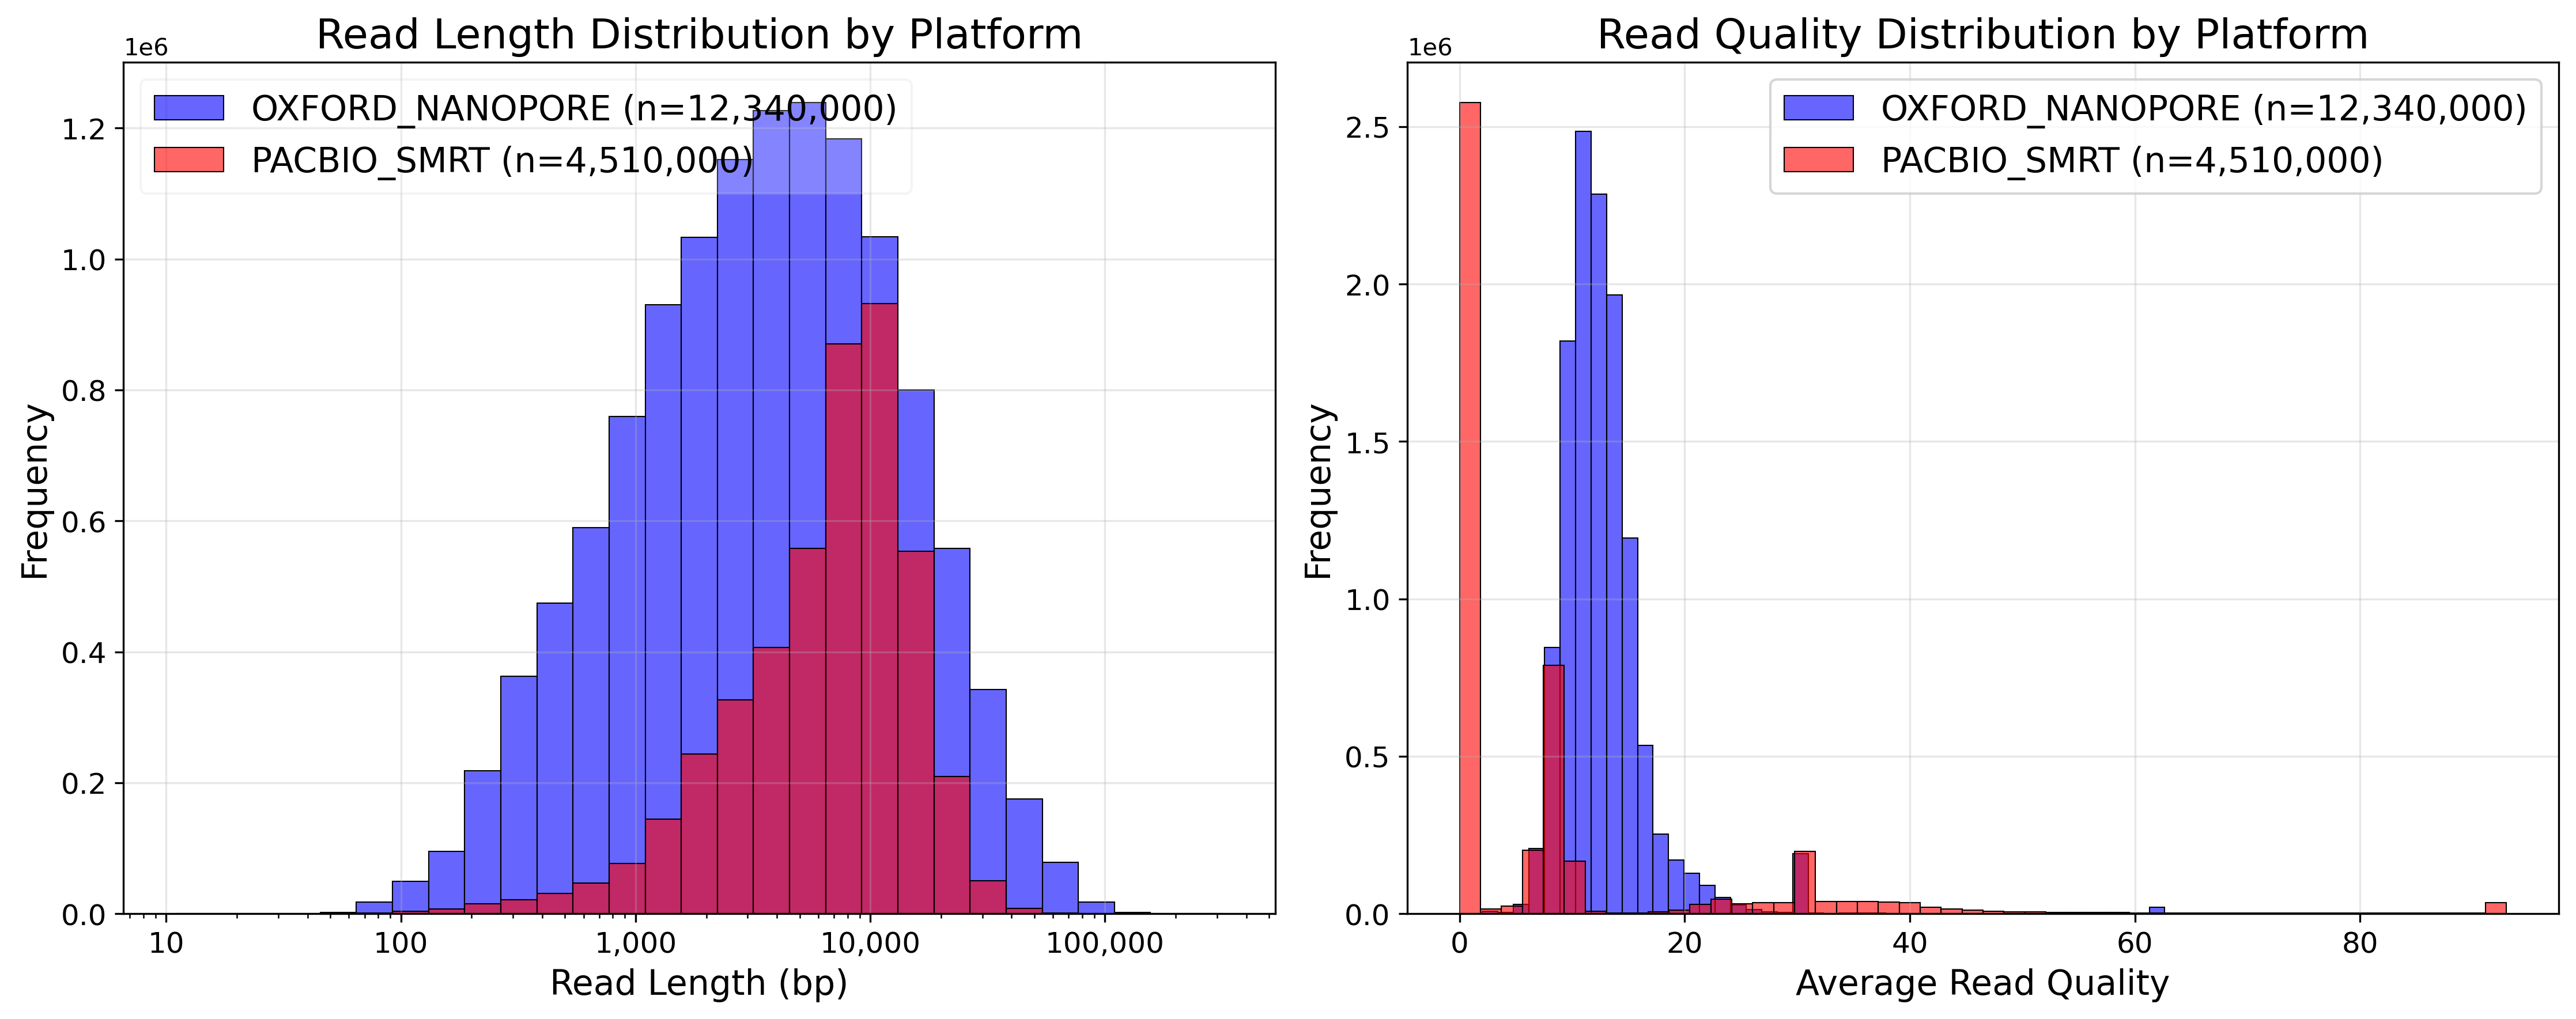

<Figure size 640x480 with 0 Axes>

In [25]:
# Distribution plots by platform (using 5% sample for faster plotting)
import seaborn as sns
plt.figure(figsize=(15, 6), dpi=300)

# Sample 5% of the data for faster plotting
sample_size = int(len(df))# * 0.05)
df_sample = df.sample(n=sample_size, random_state=42)
print(f"Using {len(df_sample):,} samples ({len(df_sample)/len(df)*100:.1f}%) for plotting")

# Define colors for platforms
platform_colors = {
    'OXFORD_NANOPORE': 'blue',
    'PACBIO_SMRT': 'red'
}

# Plot 1: Read Length Distribution by Platform
plt.subplot(1, 2, 1)

# Create logarithmically spaced bins for uniform bar widths on log scale
min_length = df_sample['read_length'].min()
max_length = df_sample['read_length'].max()
log_bins = np.logspace(np.log10(min_length), np.log10(max_length), 30)

# Use seaborn for histograms
for platform in df_sample['platform'].unique():
    platform_data = df_sample[df_sample['platform'] == platform]
    sns.histplot(data=platform_data, x='read_length', bins=log_bins, alpha=0.6, 
                color=platform_colors[platform], 
                label=f'{platform} (n={len(platform_data):,})',
                edgecolor='black', linewidth=0.5)

plt.xlabel('Read Length (bp)', fontsize="x-large")
plt.ylabel('Frequency', fontsize="x-large")
plt.title('Read Length Distribution by Platform', fontsize="xx-large")
plt.xscale('log')
# plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize="large")
plt.legend(fontsize="x-large", loc="upper left", framealpha=0.2)

xticks = [10, 100, 1_000, 10_000, 100_000]
plt.xticks(xticks, [f'{x:,}' for x in xticks])  # Format x-ticks with commas

# Add summary statistics (using full dataset)
for platform in df['platform'].unique():
    platform_data = df[df['platform'] == platform]['read_length']
    mean_length = platform_data.mean()
    median_length = platform_data.median()
    print(f"{platform} - Read Length: Mean={mean_length:.0f} bp, Median={median_length:.0f} bp")

print()

# Plot 2: Read Quality Distribution by Platform
plt.subplot(1, 2, 2)

# Use seaborn for histograms
for platform in df_sample['platform'].unique():
    platform_data = df_sample[df_sample['platform'] == platform]
    sns.histplot(data=platform_data, x='read_quality', bins=50, alpha=0.6, 
                color=platform_colors[platform], 
                label=f'{platform} (n={len(platform_data):,})',
                edgecolor='black', linewidth=0.5)

plt.xlabel('Average Read Quality', fontsize="x-large")
plt.ylabel('Frequency', fontsize="x-large")
plt.title('Read Quality Distribution by Platform', fontsize="xx-large")
# plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tick_params(axis='both', which='major', labelsize="large")
plt.legend(fontsize="x-large")

# Add summary statistics (using full dataset)
for platform in df['platform'].unique():
    platform_data = df[df['platform'] == platform]['read_quality']
    mean_quality = platform_data.mean()
    median_quality = platform_data.median()
    print(f"{platform} - Read Quality: Mean={mean_quality:.2f}, Median={median_quality:.2f}")

plt.tight_layout()
plt.show()
plt.savefig("read_len_qual.pdf")

In [ ]:
# Analyze the infinity estimates in more detail
replacement_estimate = df[df['estimate'] == df['estimate'].max()]['estimate'].iloc[0]
replacement_rel_error = df[df['relative_error'] == df['relative_error'].max()]['relative_error'].iloc[0]

infinity_mask = (df['estimate'] == replacement_estimate) | (df['relative_error'] == replacement_rel_error)
finite_mask = ~infinity_mask

print("=== INFINITY ESTIMATES ANALYSIS ===")
print(f"Total reads: {len(df):,}")
print(f"Reads with infinity estimates: {infinity_mask.sum():,} ({infinity_mask.sum()/len(df)*100:.1f}%)")
print(f"Reads with finite estimates: {finite_mask.sum():,} ({finite_mask.sum()/len(df)*100:.1f}%)")
print()

print("Read length distribution for infinity estimates:")
inf_length_stats = df[infinity_mask]['read_length'].describe()
print(f"  Mean: {inf_length_stats['mean']:.0f} bp")
print(f"  Median: {inf_length_stats['50%']:.0f} bp")
print(f"  Range: {inf_length_stats['min']:.0f} - {inf_length_stats['max']:.0f} bp")
print()

print("Read quality distribution for infinity estimates:")
inf_quality_stats = df[infinity_mask]['read_quality'].describe()
print(f"  Mean: {inf_quality_stats['mean']:.2f}")
print(f"  Median: {inf_quality_stats['50%']:.2f}")
print(f"  Range: {inf_quality_stats['min']:.2f} - {inf_quality_stats['max']:.2f}")
print()

print("Comparison with finite estimates:")
finite_length_mean = df[finite_mask]['read_length'].mean()
finite_quality_mean = df[finite_mask]['read_quality'].mean()
print(f"  Finite estimates - Length mean: {finite_length_mean:.0f} bp, Quality mean: {finite_quality_mean:.2f}")
print(f"  Infinity estimates - Length mean: {inf_length_stats['mean']:.0f} bp, Quality mean: {inf_quality_stats['mean']:.2f}")

In [ ]:
# Additional analysis plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribution of read lengths
axes[0, 0].hist(df['read_length'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Read Length (bp)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Read Lengths')
axes[0, 0].grid(True, alpha=0.3)

# Distribution of read qualities
axes[0, 1].hist(df['read_quality'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Average Read Quality')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Read Qualities')
axes[0, 1].grid(True, alpha=0.3)

# Distribution of relative errors
axes[0, 2].hist(df['relative_error'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 2].set_xlabel('Relative Error (%)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution of Relative Errors')
axes[0, 2].grid(True, alpha=0.3)

# Boxplot: Relative Error by Read Length Quartiles
df['length_quartile'] = pd.qcut(df['read_length'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df.boxplot(column='relative_error', by='length_quartile', ax=axes[1, 0])
axes[1, 0].set_title('Relative Error by Read Length Quartiles')
axes[1, 0].set_xlabel('Read Length Quartile')
axes[1, 0].set_ylabel('Relative Error (%)')

# Boxplot: Relative Error by Read Quality Quartiles
df['quality_quartile'] = pd.qcut(df['read_quality'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
df.boxplot(column='relative_error', by='quality_quartile', ax=axes[1, 1])
axes[1, 1].set_title('Relative Error by Read Quality Quartiles')
axes[1, 1].set_xlabel('Read Quality Quartile')
axes[1, 1].set_ylabel('Relative Error (%)')

# Correlation heatmap
correlation_data = df[['read_length', 'read_quality', 'relative_error', 'estimate', 'true_size']].corr()
im = axes[1, 2].imshow(correlation_data, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1, 2].set_xticks(range(len(correlation_data.columns)))
axes[1, 2].set_yticks(range(len(correlation_data.columns)))
axes[1, 2].set_xticklabels(correlation_data.columns, rotation=45)
axes[1, 2].set_yticklabels(correlation_data.columns)
axes[1, 2].set_title('Correlation Matrix')

# Add correlation values to the heatmap
for i in range(len(correlation_data.columns)):
    for j in range(len(correlation_data.columns)):
        text = axes[1, 2].text(j, i, f'{correlation_data.iloc[i, j]:.2f}',
                              ha="center", va="center", color="black", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate and display correlation coefficients
from scipy.stats import pearsonr, spearmanr

print("=== CORRELATION ANALYSIS ===")
print()

# Pearson correlation: read length vs relative error
corr_length_pearson, p_val_length_pearson = pearsonr(df['read_length'], df['relative_error'])
print(f"Read Length vs Relative Error:")
print(f"  Pearson correlation: {corr_length_pearson:.4f} (p-value: {p_val_length_pearson:.2e})")

# Spearman correlation: read length vs relative error
corr_length_spearman, p_val_length_spearman = spearmanr(df['read_length'], df['relative_error'])
print(f"  Spearman correlation: {corr_length_spearman:.4f} (p-value: {p_val_length_spearman:.2e})")
print()

# Pearson correlation: read quality vs relative error
corr_quality_pearson, p_val_quality_pearson = pearsonr(df['read_quality'], df['relative_error'])
print(f"Read Quality vs Relative Error:")
print(f"  Pearson correlation: {corr_quality_pearson:.4f} (p-value: {p_val_quality_pearson:.2e})")

# Spearman correlation: read quality vs relative error
corr_quality_spearman, p_val_quality_spearman = spearmanr(df['read_quality'], df['relative_error'])
print(f"  Spearman correlation: {corr_quality_spearman:.4f} (p-value: {p_val_quality_spearman:.2e})")
print()

print("=== SUMMARY STATISTICS ===")
print()
print("Read Length Statistics:")
print(f"  Mean: {df['read_length'].mean():.0f} bp")
print(f"  Median: {df['read_length'].median():.0f} bp")
print(f"  Std: {df['read_length'].std():.0f} bp")
print(f"  Range: {df['read_length'].min():.0f} - {df['read_length'].max():.0f} bp")
print()

print("Read Quality Statistics:")
print(f"  Mean: {df['read_quality'].mean():.2f}")
print(f"  Median: {df['read_quality'].median():.2f}")
print(f"  Std: {df['read_quality'].std():.2f}")
print(f"  Range: {df['read_quality'].min():.2f} - {df['read_quality'].max():.2f}")
print()

print("Relative Error Statistics:")
print(f"  Mean: {df['relative_error'].mean():.2f}%")
print(f"  Median: {df['relative_error'].median():.2f}%")
print(f"  Std: {df['relative_error'].std():.2f}%")
print(f"  Range: {df['relative_error'].min():.2f}% - {df['relative_error'].max():.2f}%")